In [1]:
from skimage import io
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA
from skimage.transform import SimilarityTransform
from skimage.transform import warp
import os
import random
import pathlib

In [2]:
def read_landmark_file(file_name):
    f = open(file_name, 'r')
    lm_s = f.readline().strip().split(' ')
    n_lms = int(lm_s[0])
    if n_lms < 3:
        print(f"Not enough landmarks found")
        return None

    new_lms = 3
    # 3 landmarks each with (x,y)
    lm = np.zeros((new_lms, 2))
    for i in range(new_lms):
        lm[i, 0] = lm_s[1 + i * 2]
        lm[i, 1] = lm_s[2 + i * 2]
    return lm

In [3]:
cat_img = read_landmark_file('data/ModelCat.jpg.cat')

In [6]:
cat_img

array([[154., 173.],
       [255., 163.],
       [222., 254.]])

In [4]:
def align_and_crop_one_cat_to_destination_cat(img_src, lm_src, img_dst, lm_dst):
    """
    Landmark based alignment of one cat image to a destination
    :param img_src: Image of source cat
    :param lm_src: Landmarks for source cat
    :param lm_dst: Landmarks for destination cat
    :return: Warped and cropped source image. None if something did not work
    """
    tform = SimilarityTransform()
    tform.estimate(lm_src, lm_dst)
    warped = warp(img_src, tform.inverse, output_shape=img_dst.shape)

    # Center of crop region
    cy = 185
    cx = 210
    # half the size of the crop box
    sz = 180
    warp_crop = warped[cy - sz:cy + sz, cx - sz:cx + sz]
    shape = warp_crop.shape
    if shape[0] == sz * 2 and shape[1] == sz * 2:
        return img_as_ubyte(warp_crop)
    else:
        print(f"Could not crop image. It has shape {shape}. Probably to close to border of image")
        return None

In [5]:
def preprocess_all_cats(in_dir, out_dir):
    """
    Create aligned and cropped version of image
    :param in_dir: Where are the original photos and landmark files
    :param out_dir: Where should the preprocessed files be placed
    """
    dst = "data/ModelCat"
    dst_lm = read_landmark_file(f"{dst}.jpg.cat")

    dst_img = io.imread(f"{dst}.jpg")

    all_images = glob.glob(in_dir + "*.jpg")
    print(all_images)
    for img_idx in all_images:
        name_no_ext = os.path.splitext(img_idx)[0]
        base_name = os.path.basename(name_no_ext)
        out_name = f"{out_dir}/{base_name}_preprocessed.jpg"

        src_lm = read_landmark_file(f"{name_no_ext}.jpg.cat")
        src_img = io.imread(f"{name_no_ext}.jpg")

        proc_img = align_and_crop_one_cat_to_destination_cat(src_img, src_lm, dst_img, dst_lm)

        if proc_img is not None:
            io.imsave(out_name, proc_img)


In [6]:
preprocess_all_cats('data/training_cats_100/', 'data/preprocessed_cats')

['data/training_cats_100\\00000001_000.jpg', 'data/training_cats_100\\00000001_005.jpg', 'data/training_cats_100\\00000001_008.jpg', 'data/training_cats_100\\00000001_011.jpg', 'data/training_cats_100\\00000001_012.jpg', 'data/training_cats_100\\00000001_016.jpg', 'data/training_cats_100\\00000001_017.jpg', 'data/training_cats_100\\00000001_020.jpg', 'data/training_cats_100\\00000001_024.jpg', 'data/training_cats_100\\00000001_027.jpg', 'data/training_cats_100\\00000001_029.jpg', 'data/training_cats_100\\00000002_001.jpg', 'data/training_cats_100\\00000002_003.jpg', 'data/training_cats_100\\00000002_008.jpg', 'data/training_cats_100\\00000002_026.jpg', 'data/training_cats_100\\00000003_007.jpg', 'data/training_cats_100\\00000003_009.jpg', 'data/training_cats_100\\00000003_012.jpg', 'data/training_cats_100\\00000003_013.jpg', 'data/training_cats_100\\00000003_015.jpg', 'data/training_cats_100\\00000003_020.jpg', 'data/training_cats_100\\00000003_024.jpg', 'data/training_cats_100\\000000

In [7]:
preprocessed_cats = glob.glob('data/preprocessed_cats/*.jpg')
n_samples = len(preprocessed_cats)
h_w_c = list(io.imread(preprocessed_cats[0]).shape)
n_features = h_w_c[0] * h_w_c[1] * h_w_c[2]
data_matrix = np.zeros((n_samples, n_features))

In [8]:
for idx in range(n_samples):
    flatten_img = io.imread(preprocessed_cats[idx]).ravel()
    data_matrix[idx, :] = flatten_img

In [9]:
mean_cat = np.mean(data_matrix, axis = 0)

In [10]:
def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

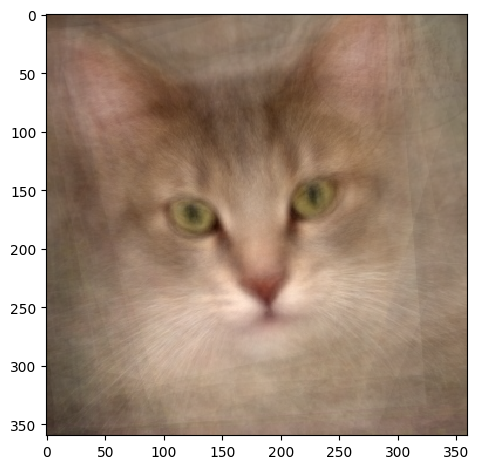

In [56]:
mean_cat_img = create_u_byte_image_from_vector(mean_cat, 360, 360, 3)
io.imshow(mean_cat_img)

In [11]:
def preprocess_one_cat():
    src = "data/MissingCat"
    dst = "data/ModelCat"
    out = "data/MissingCatProcessed.jpg"

    src_lm = read_landmark_file(f"{src}.jpg.cat")
    dst_lm = read_landmark_file(f"{dst}.jpg.cat")

    src_img = io.imread(f"{src}.jpg")
    dst_img = io.imread(f"{dst}.jpg")

    src_proc = align_and_crop_one_cat_to_destination_cat(src_img, src_lm, dst_img, dst_lm)
    if src_proc is None:
        return

    io.imsave(out, src_proc)

    fig, ax = plt.subplots(ncols=3, figsize=(16, 6))
    ax[0].imshow(src_img)
    ax[0].plot(src_lm[:, 0], src_lm[:, 1], '.r', markersize=12)
    ax[1].imshow(dst_img)
    ax[1].plot(dst_lm[:, 0], dst_lm[:, 1], '.r', markersize=12)
    ax[2].imshow(src_proc)
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()

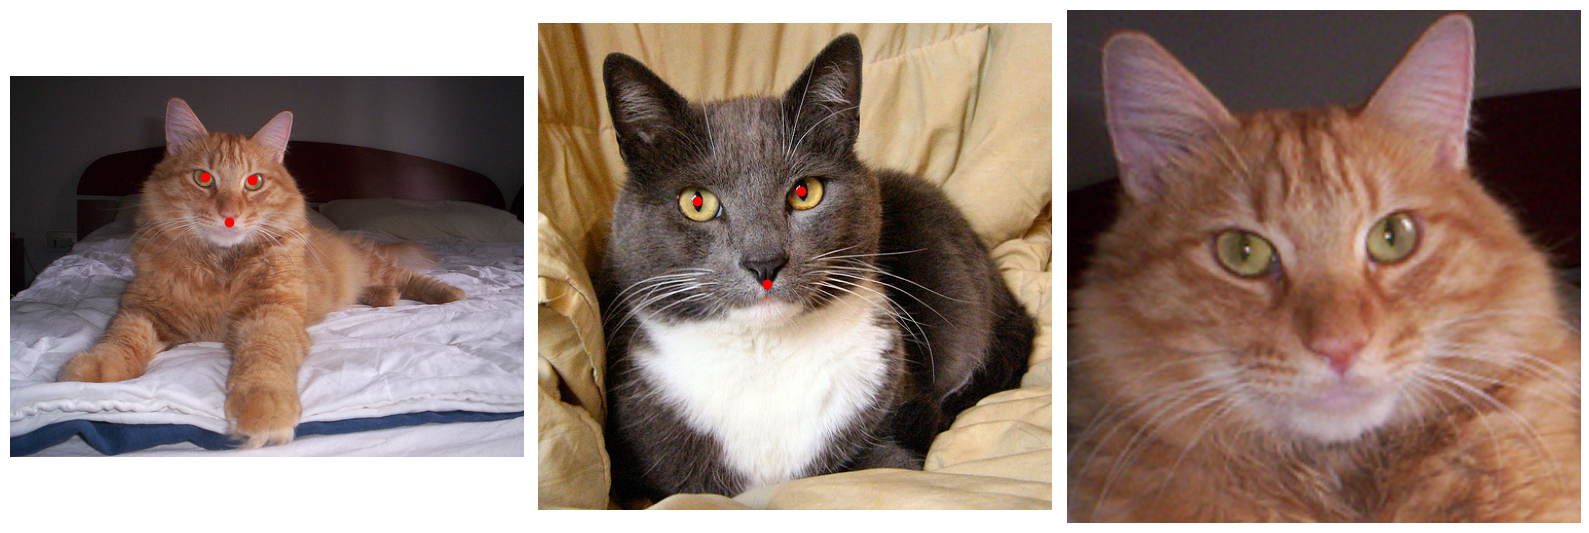

In [58]:
preprocess_one_cat()

In [12]:
missing_cat = io.imread('data/MissingCatProcessed.jpg')
flatten_missing_cat = missing_cat.ravel()

In [38]:
sub_distances = []

sub_data = data_matrix - flatten_missing_cat
sub_distances = np.linalg.norm(sub_data, axis = 1)

print(np.argmax(sub_distances))
#plt.imshow(create_u_byte_image_from_vector(data_matrix[32], 360, 360, 3))


9


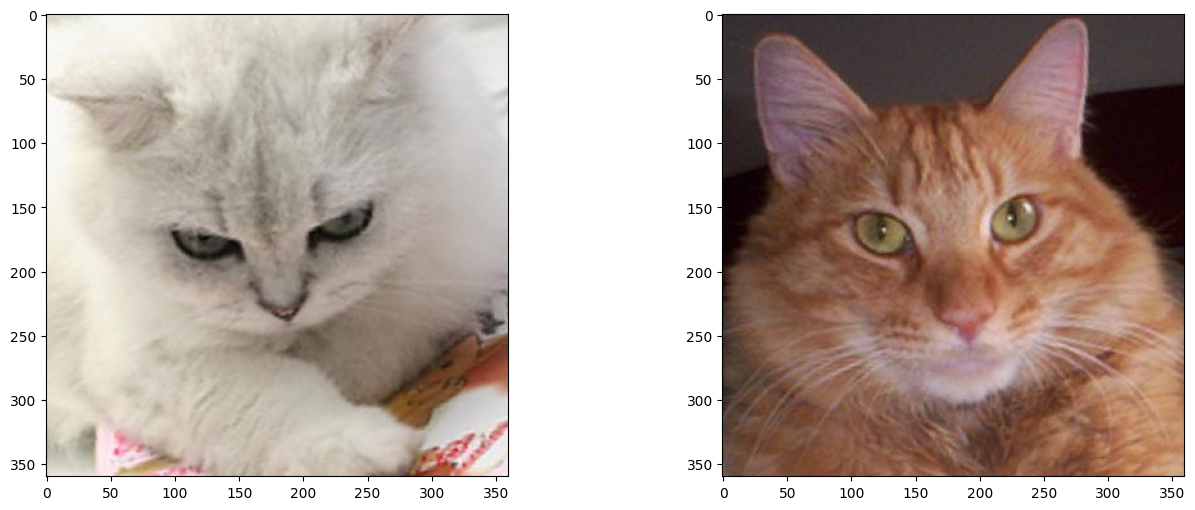

In [77]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
ax[0].imshow(create_u_byte_image_from_vector(data_matrix[9], 360, 360, 3))
ax[1].imshow(missing_cat)


In [13]:
print("Computing PCA")
cats_pca = PCA(n_components=50)
cats_pca.fit(data_matrix)
print('Done')

Computing PCA
Done


In [81]:
y = cats_pca.explained_variance_ratio_
x = list(range(len(y)))

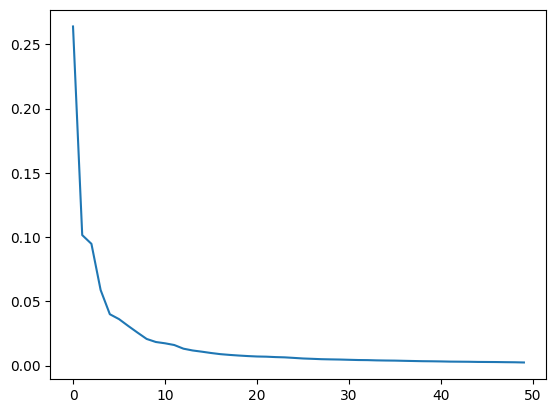

In [82]:
plt.plot(x,y)

In [24]:
components = cats_pca.transform(data_matrix)

In [86]:
pc1 = components[:, 0]
pc2 = components[:, 1]

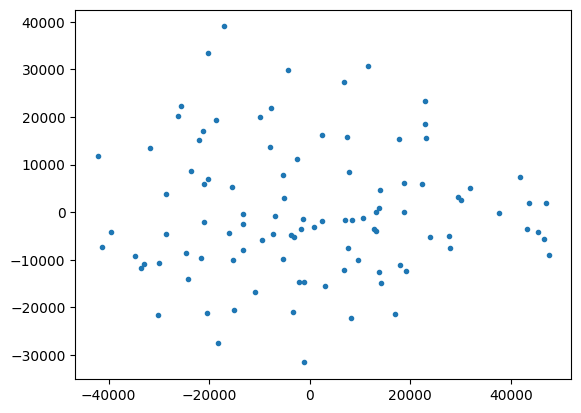

In [88]:
plt.plot(pc1, pc2, '.')

In [90]:
min_cat_pc1 =np.argmin(pc1)
max_cat_pc1 =np.argmax(pc1)
min_cat_pc2 =np.argmin(pc2)
max_cat_pc2 =np.argmax(pc2)

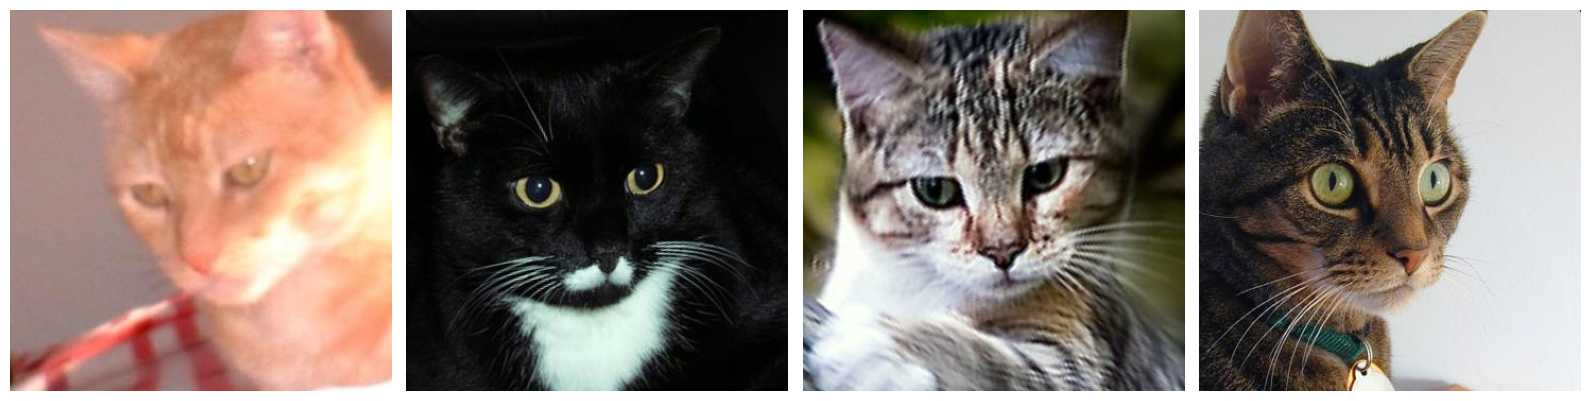

In [94]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 6))
ax[0].imshow(create_u_byte_image_from_vector(data_matrix[min_cat_pc1], 360,360,3))
ax[1].imshow(create_u_byte_image_from_vector(data_matrix[max_cat_pc1], 360,360,3))
ax[2].imshow(create_u_byte_image_from_vector(data_matrix[min_cat_pc2], 360,360,3))
ax[3].imshow(create_u_byte_image_from_vector(data_matrix[max_cat_pc2], 360,360,3))
for a in ax:
       a.axis('off')
plt.tight_layout()
plt.show()

In [14]:
def plot_beautiful_img(img, img2 = [], vector = False, size = (360,360,3)):
    if vector:
        img = create_u_byte_image_from_vector(img, *size)

    if not len(img2):


        fig, ax = plt.subplots(nrows=1, figsize = (8,4))
        ax.imshow(img)
        ax.axis('off')
    else:
        if vector:
            img2 = create_u_byte_image_from_vector(img2, *size)

        fig, ax = plt.subplots(ncols=2, figsize = (16,8))
        ax[0].imshow(img)
        ax[1].imshow(img2)
        ax[1].axis('off')
        ax[0].axis('off')
    plt.tight_layout()
    plt.show()


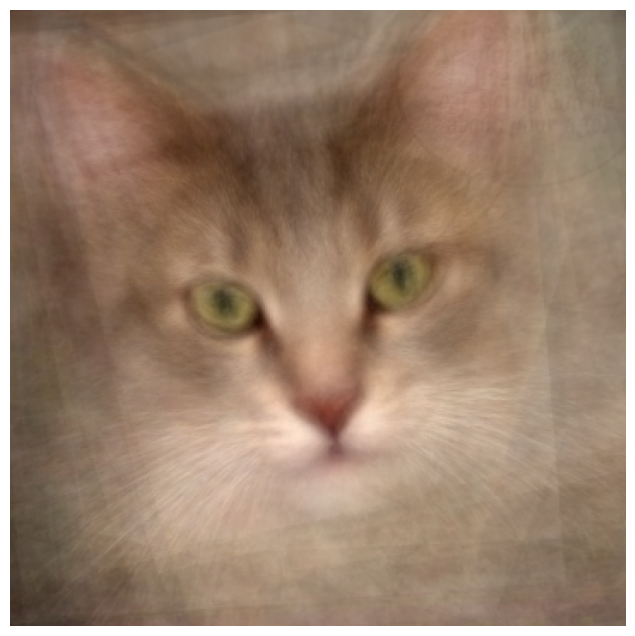

In [123]:
w = 1000
synth_cat = mean_cat + w * cats_pca.components_[0, :] + w * cats_pca.components_[1, :]
plot_beautiful_img(create_u_byte_image_from_vector(synth_cat, 360, 360, 3))

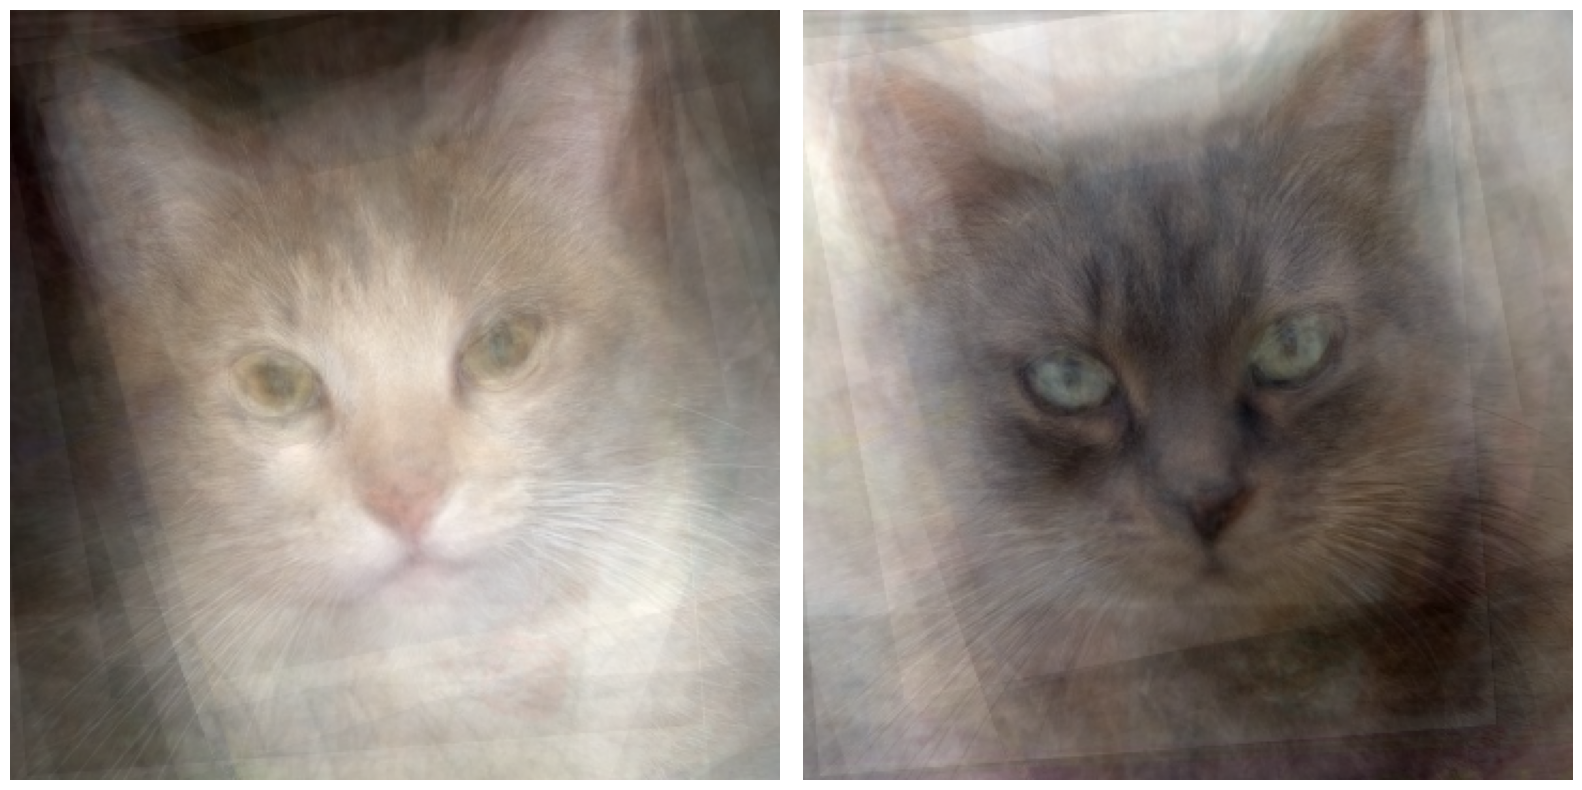

In [146]:
comp = 2
synth_cat_plus = mean_cat + 3 * np.sqrt(cats_pca.explained_variance_[comp]) * cats_pca.components_[comp, :]
synth_cat_minus = mean_cat - 3 * np.sqrt(cats_pca.explained_variance_[comp]) * cats_pca.components_[comp, :]
plot_beautiful_img(synth_cat_plus, synth_cat_minus, vector = True)

In [148]:
n_components_to_use = 10
synth_cat = mean_cat
for idx in range(n_components_to_use):
	w = random.uniform(-1, 1) * 3 * np.sqrt(cats_pca.explained_variance_[idx])
	synth_cat = synth_cat + w * cats_pca.components_[idx, :]

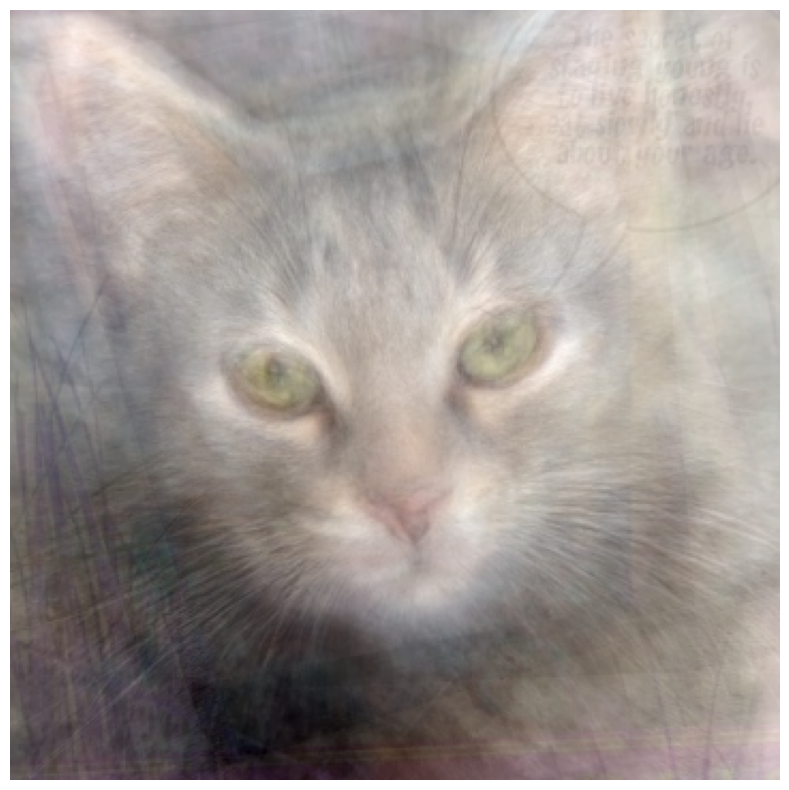

In [153]:
plot_beautiful_img(synth_cat, vector = True)

In [32]:
im_miss = io.imread("data/MissingCatProcessed.jpg")
im_miss_flat = im_miss.flatten()
im_miss_flat = im_miss_flat.reshape(1, -1)
pca_coords = cats_pca.transform(im_miss_flat)
print(pca_coords.shape)
pca_coords = pca_coords.flatten()


(1, 50)


In [19]:
n_components_to_use = 4
synth_cat = mean_cat
for idx in range(n_components_to_use):
	synth_cat = synth_cat + pca_coords[idx] * cats_pca.components_[idx, :]

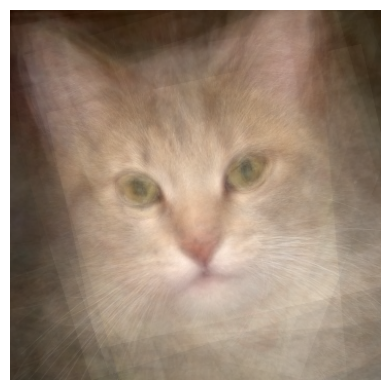

In [21]:
plot_beautiful_img(synth_cat, vector = True)

In [33]:
comp_sub = components - pca_coords
pca_distances = np.linalg.norm(comp_sub, axis=1)

np.argmax(pca_distances)

79

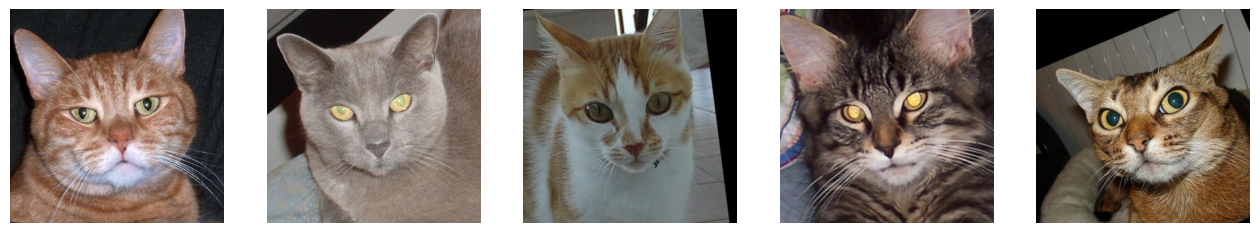

In [36]:
indexes = pca_distances.argsort()[:5]
fig, ax = plt.subplots(nrows=1, ncols=5, figsize = (16,8))
for i in range(5):
    ax[i].imshow(create_u_byte_image_from_vector(data_matrix[indexes[i]], 360,360,3))
    ax[i].axis('off')
#plt.thight_layout()
plt.show()

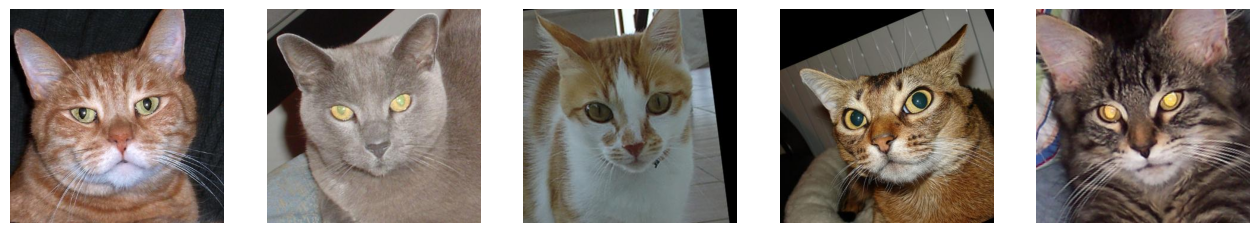

In [39]:
indexes = sub_distances.argsort()[:5]
fig, ax = plt.subplots(nrows=1, ncols=5, figsize = (16,8))
for i in range(5):
    ax[i].imshow(create_u_byte_image_from_vector(data_matrix[indexes[i]], 360,360,3))
    ax[i].axis('off')
#plt.thight_layout()
plt.show()